## Exoplanet Model Work



#### Import packages

In [17]:
import pydot
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import io
from keras.utils import plot_model
import random
import yaml
#import ktrain
from astropy.io import ascii as ap_ascii
import seaborn as sns
import os

import matplotlib as mpl
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

pd.set_option('display.float_format', lambda x: '%.5f' % x)
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.set_printoptions(precision=None, suppress=True)

from helpers.visualize import chart_curves 
from definitions import PROCESSED_DATA_DIR,PROCESSED_DATA_CATALOG
#PROCESSED_DATA_DIR='processed_data'
TCE_LIST='tce_table.csv'
FAILED_LIST='failed_kepids.csv'
MODEL_DIR='models'

BATCH_SIZE=96

#### Model analysis plotting and charting functions

In [2]:
def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

        plt.legend()
    plt.show()


#roc curve
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

#confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print('Not Planets Properly Categorized (True Negatives): ', cm[0][0])
    print('Not Planets Categorized as Planets Detected (False Positives): ', cm[0][1])
    print('Planets Missed (False Negatives): ', cm[1][0])
    print('Planets Properly Categorized (True Positives): ', cm[1][1])
    print('Total Planets: ', np.sum(cm[1]))
    print('Accuracy: ',(cm[0][0]+cm[1][1])/len(predictions))
    
#takes in the tce index number, the tce id table, the results table (which figures out tp etc),
#and the two vector tables and then calls the visualization helper function which
#creates a chart and saves inside of processed_data folder structure
def chart(tce_number,tce_id,results,x_global,x_local):
    kepid=tce_id.loc[tce_number].kepid
    result=val_results.loc[tce_number].result
    tce_plnt_num=tce_id.loc[tce_number].tce_plnt_num
    chart_curves(str(kepid),tce_plnt_num,
             result,
             x_global_val[tce_number],x_local_val[tce_number])
    

#### Construct and return a model

In [3]:
#make the model
METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')
    ]


def make_model(metrics=METRICS,output_bias=None):
    input_local = tf.keras.layers.Input(shape=[x_local.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global.shape[1],1])

    #k_local = tf.keras.layers.BatchNormalization()(input_local)
    #k_local=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(k_local)
    k_local=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(input_local)

    k_local=tf.keras.layers.Conv1D(16,5,activation='relu')(k_local)
    k_local=tf.keras.layers.MaxPooling1D(pool_size=7,strides=2,padding='same')(k_local)
    k_local=tf.keras.layers.Conv1D(32,5,activation='relu')(k_local)
    k_local=tf.keras.layers.Conv1D(32,5,activation='relu')(k_local)
    k_local=tf.keras.layers.MaxPooling1D(pool_size=7,strides=2,padding='same')(k_local)
    k_local=tf.keras.layers.Flatten()(k_local)

    #k_global=tf.keras.layers.BatchNormalization()(input_global)
    #k_global=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(k_global)
    k_global=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(input_global)

    k_global=tf.keras.layers.Conv1D(16,5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    k_global=tf.keras.layers.Conv1D(32,5,activation='relu')(k_global)
    k_global=tf.keras.layers.Conv1D(32,5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    #k_global=tf.keras.layers.Conv1D(64,5,activation='relu')(k_global)
    #k_global=tf.keras.layers.Conv1D(64,5,activation='relu')(k_global)
    #k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    #k_global=tf.keras.layers.Conv1D(128,5,activation='relu')(k_global)
    #k_global=tf.keras.layers.Conv1D(128,5,activation='relu')(k_global)
    #k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    #k_global=tf.keras.layers.Conv1D(256,5,activation='relu')(k_global)
    #k_global=tf.keras.layers.Conv1D(256,5,activation='relu')(k_global)
    #k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    k_global=tf.keras.layers.Flatten()(k_global)

    #combines two branches
    k = tf.keras.layers.concatenate([k_local, k_global])

    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(.6)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    #k=tf.keras.layers.Dropout(.6)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    #k=tf.keras.layers.Dropout(.6)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(.6)(k)

    if output_bias is not None:
        output_bias=tf.keras.initializers.Constant(output_bias)
        
    output=tf.keras.layers.Dense(1,activation='sigmoid',bias_initializer=output_bias)(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                  metrics=METRICS)

    return(model)

#### Read in and process data for use in model

In [4]:
#this excludes from tce_list those kepids and planet numbers that failed make_data process
processed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,TCE_LIST))
print(processed.shape)
try:
    failed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,FAILED_LIST))
    failed.columns=['kepid','tce_plnt_num']
    print(failed.shape)
    for index,row in failed.iterrows():
        processed.drop(processed[(processed.kepid==row.kepid) & 
                                 (processed.tce_plnt_num==row.tce_plnt_num)].index,inplace=True)
except:
    pass
    
processed=processed.reset_index(drop=True)
print(processed.shape)

#maybe need to save processed with failed KEPIDs in it and with a flag - do analysis of how many of those
#are confirmed?

#save processed list back out (so excludes those KEPIDS/PLNTs with NO light curves)
processed.to_csv(os.path.join(PROCESSED_DATA_DIR,PROCESSED_DATA_CATALOG),index=False)

(34032, 86)
(438, 2)
(33594, 86)


In [5]:
print(processed.koi_disposition.value_counts())

#combine confirmed and candidate
#using 0 and 1 in front of name to force positive class to be planets
processed.replace({'koi_disposition':
                   {'CANDIDATE':'1-CONFIRMED','CONFIRMED':'1-CONFIRMED','FALSE POSITIVE':'0-FALSE POSITIVE'}},
                  inplace=True)

print(processed.koi_disposition.value_counts())
print('Baseline accuracy:', processed[processed.koi_disposition=='0-FALSE POSITIVE'].shape[0]/processed.shape[0])



FALSE POSITIVE    29397
CONFIRMED          2345
CANDIDATE          1852
Name: koi_disposition, dtype: int64
0-FALSE POSITIVE    29397
1-CONFIRMED          4197
Name: koi_disposition, dtype: int64
Baseline accuracy: 0.8750669762457581


In [6]:
LOCAL='localbinned_df.csv'
GLOBAL='globalbinned_df.csv'
x_local=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,LOCAL))
x_global=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,GLOBAL))
print(x_local.shape)
print(x_global.shape)

(33594, 201)
(33594, 2001)


In [7]:
#add kepid and tce_plnt_number to x
tce_id=pd.DataFrame()
tce_id['kepid']=processed.kepid.astype('int')
tce_id['tce_plnt_num']=processed.tce_plnt_num.astype('int')
tce_id['koi_disposition']=processed.koi_disposition


In [8]:
#turn into numpy arrays/series
x_local=x_local.to_numpy()
x_global=x_global.to_numpy()
print(x_local.shape)
print(x_global.shape)

(33594, 201)
(33594, 2001)


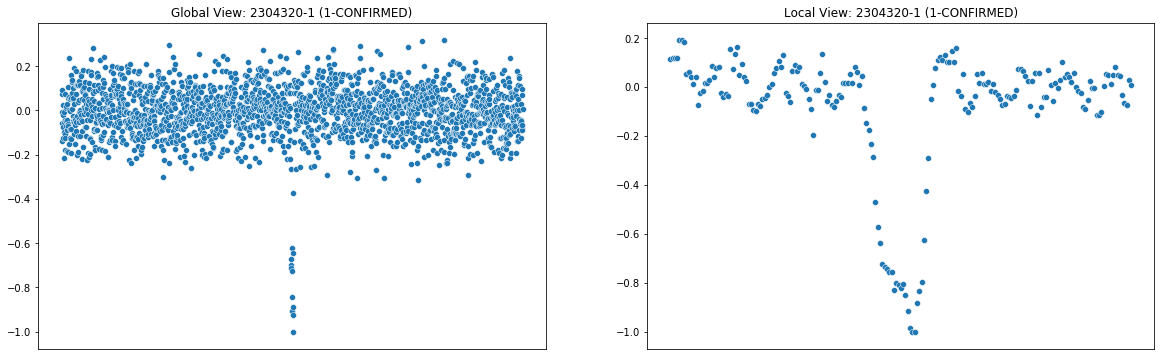

In [9]:
#can print out charts
tce_number=3
chart_curves(tce_id.kepid[tce_number],
             tce_id.tce_plnt_num[tce_number],
             x_global[tce_number],
             x_local[tce_number],
             tce_id.koi_disposition[tce_number])



In [10]:
#scaler_local = StandardScaler()
#x_local= scaler_local.fit_transform(x_local)

#scaler_global=StandardScaler()
#x_global=scaler_global.fit_transform(x_global)


In [11]:
#Conv1D layers take in tensors of dimension (length of vector = 201 or 2001, and dimensions of vector=1)
#So as with Conv2D in BW where need to add a color dimension here have to specify that there is only one
#dimension in each vector
x_local=np.expand_dims(x_local,axis=2)
x_global=np.expand_dims(x_global,axis=2)

print(x_local.shape)
print(x_global.shape)

(33594, 201, 1)
(33594, 2001, 1)


In [12]:
#turn output into categorical variable with encoding
Y=processed.koi_disposition
le=LabelEncoder()
le.fit(['1-CONFIRMED','0-FALSE POSITIVE'])
Y=le.transform(Y)

In [13]:
x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val,tce_id_train,tce_id_val = train_test_split(
    x_local,x_global, Y,tce_id, test_size=0.2)

print(x_local_train.shape)
print(x_global_train.shape)
print(Y_train.shape)
print(tce_id_train.shape)
print(x_local_val.shape)
print(x_global_val.shape)
print(Y_val.shape)
print(tce_id_val.shape)

(26875, 201, 1)
(26875, 2001, 1)
(26875,)
(26875, 3)
(6719, 201, 1)
(6719, 2001, 1)
(6719,)
(6719, 3)


#### Model setup work

In [18]:
#work on setting initial bias
tf.keras.backend.clear_session()
model=make_model()
model.predict([x_local_train[:10],x_global_train[:10]])
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))
neg, pos = np.bincount(Y)
total = neg + pos
print(neg,pos,total)
initial_bias=np.log([pos/neg])
print(initial_bias)
model = make_model(output_bias = initial_bias)
model.predict([x_local_train[:10],x_global_train[:10]])
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

initial_weights = os.path.join(MODEL_DIR,'initial_weights')
model.save_weights(initial_weights)

280/280 [==============================] - 2s 7ms/step - loss: 0.4114 - tp: 0.0000e+00 - fp: 1.0000 - tn: 23472.0000 - fn: 3402.0000 - accuracy: 0.8734 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4589
Loss: 0.4114
29397 4197 33594
[-1.94652264]
280/280 [==============================] - 2s 7ms/step - loss: 0.3796 - tp: 0.0000e+00 - fp: 1.0000 - tn: 46945.0000 - fn: 6804.0000 - accuracy: 0.8734 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4873
Loss: 0.3796


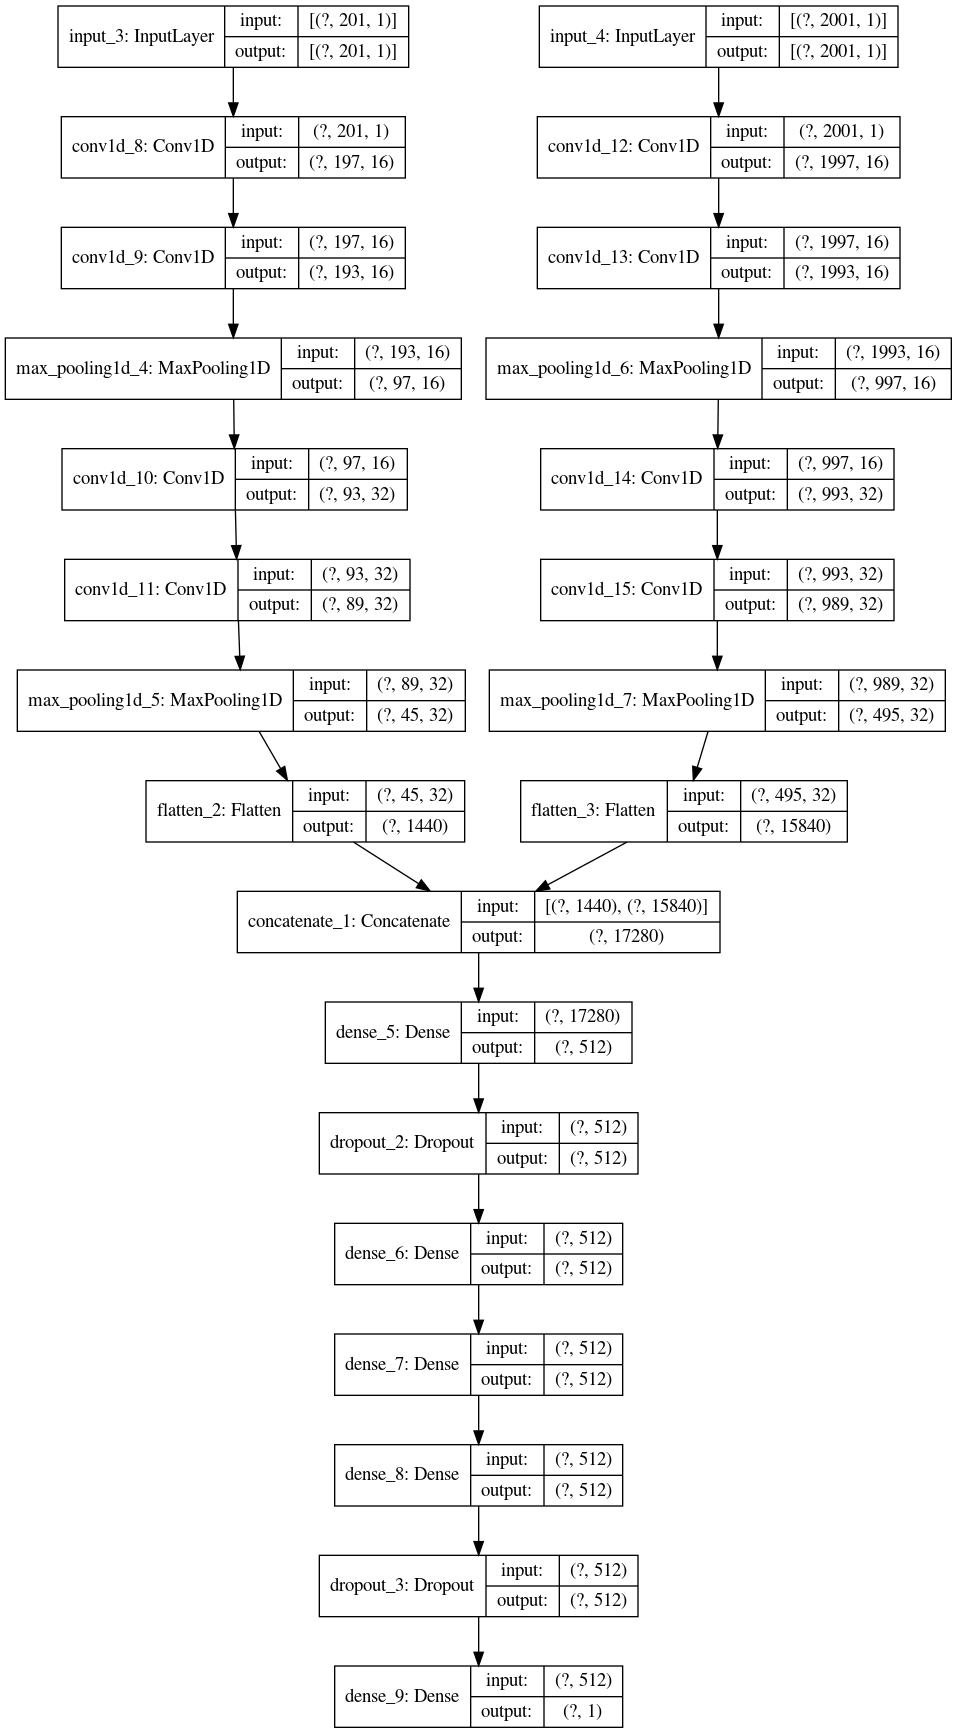

In [19]:
tf.keras.utils.plot_model(
    model, to_file=os.path.join(MODEL_DIR,'model.png'), show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 197, 16)      96          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 1997, 16)     96          input_4[0][0]                    
____________________________________________________________________________________________

#### Train model

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [22]:
tf.keras.backend.clear_session()
model=make_model()
model.load_weights(initial_weights)

#history=model.fit([x_local_train,x_global_train],
#                  Y_train,
#                  validation_data=([x_local_val,x_global_val],Y_val),
#                  steps_per_epoch=25,
#                  epochs=EPOCHS*20,
#                  callbacks=[early_stopping],
#                  verbose=1)

EPOCHS=20



history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  callbacks=[early_stopping],
                  verbose=1)



Epoch 1/20
280/280 [==============================] - 6s 22ms/step - loss: 0.1824 - tp: 2062.0000 - fp: 567.0000 - tn: 69852.0000 - fn: 8144.0000 - accuracy: 0.8920 - precision: 0.7843 - recall: 0.2020 - auc: 0.7113 - val_loss: 0.1299 - val_tp: 582.0000 - val_fp: 74.0000 - val_tn: 5850.0000 - val_fn: 213.0000 - val_accuracy: 0.9573 - val_precision: 0.8872 - val_recall: 0.7321 - val_auc: 0.9607
Epoch 2/20
280/280 [==============================] - 5s 17ms/step - loss: 0.1389 - tp: 2558.0000 - fp: 476.0000 - tn: 22997.0000 - fn: 844.0000 - accuracy: 0.9509 - precision: 0.8431 - recall: 0.7519 - auc: 0.9636 - val_loss: 0.1196 - val_tp: 609.0000 - val_fp: 67.0000 - val_tn: 5857.0000 - val_fn: 186.0000 - val_accuracy: 0.9623 - val_precision: 0.9009 - val_recall: 0.7660 - val_auc: 0.9681
Epoch 3/20
280/280 [==============================] - 5s 17ms/step - loss: 0.1253 - tp: 2721.0000 - fp: 464.0000 - tn: 23009.0000 - fn: 681.0000 - accuracy: 0.9574 - precision: 0.8543 - recall: 0.7998 - auc:

#### Save model

In [50]:
model.save(os.path.join(MODEL_DIR,'normal_model'))


INFO:tensorflow:Assets written to: models/normal_model/assets


#### Load model

In [ ]:
model = tf.keras.models.load_model(os.path.join(MODEL_DIR,'normal_model'))
model.summary()

In [23]:
val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

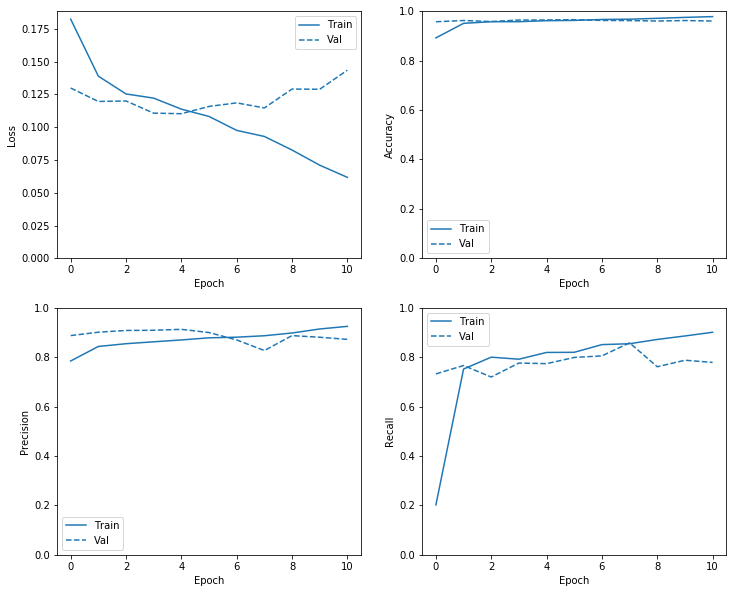

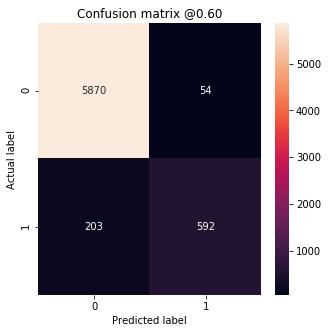

Not Planets Properly Categorized (True Negatives):  5870
Not Planets Categorized as Planets Detected (False Positives):  54
Planets Missed (False Negatives):  203
Planets Properly Categorized (True Positives):  592
Total Planets:  795
Accuracy:  0.9617502604554249


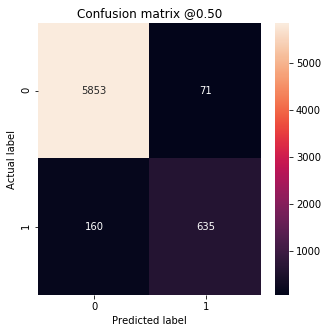

Not Planets Properly Categorized (True Negatives):  5853
Not Planets Categorized as Planets Detected (False Positives):  71
Planets Missed (False Negatives):  160
Planets Properly Categorized (True Positives):  635
Total Planets:  795
Accuracy:  0.9656198839112963


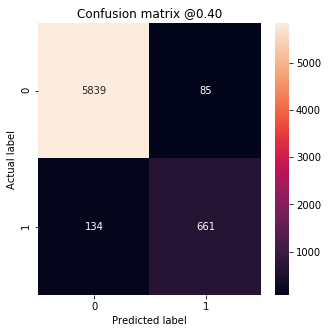

Not Planets Properly Categorized (True Negatives):  5839
Not Planets Categorized as Planets Detected (False Positives):  85
Planets Missed (False Negatives):  134
Planets Properly Categorized (True Positives):  661
Total Planets:  795
Accuracy:  0.9674058639678523


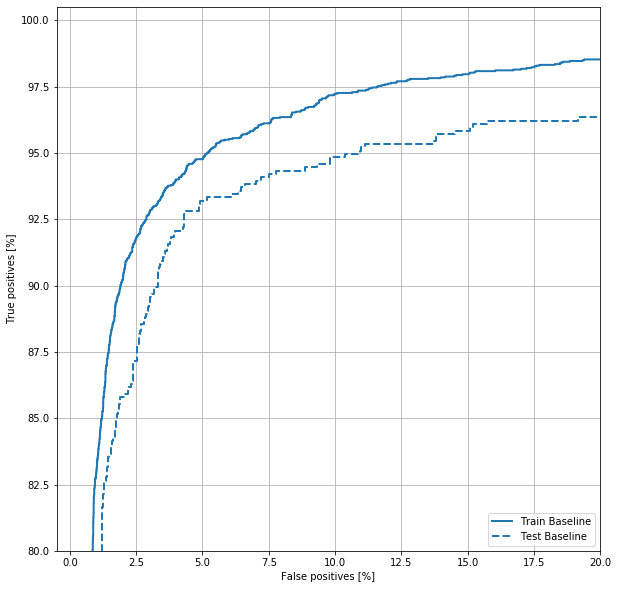

In [24]:
plot_metrics(history)

plot_cm(Y_val, val_predictions_baseline,p=.6)
plot_cm(Y_val, val_predictions_baseline)
plot_cm(Y_val, val_predictions_baseline,p=.4)


plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Create Disposition Prediction for Entire Dataset

In [28]:
full_predictions = model.predict([x_local,x_global])
full_predictions


array([[0.00292027],
       [0.00032339],
       [0.00001524],
       ...,
       [0.00307733],
       [0.0055193 ],
       [0.2659907 ]], dtype=float32)

(33594, 1)
(33594,)


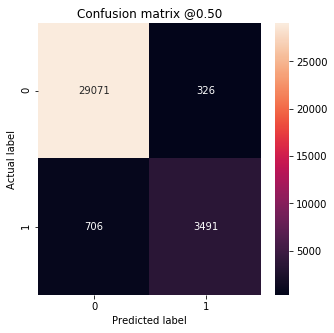

Not Planets Properly Categorized (True Negatives):  29071
Not Planets Categorized as Planets Detected (False Positives):  326
Planets Missed (False Negatives):  706
Planets Properly Categorized (True Positives):  3491
Total Planets:  4197
Accuracy:  0.9692802286122522


In [29]:
print(full_predictions.shape)
print(Y.shape)
plot_cm(Y, full_predictions)

In [117]:
processed_final=processed.copy()
processed_final['w2p_score']=full_predictions
processed_final['w2p_disposition']='FALSE POSITIVE'
processed_final.loc[processed_final.w2p_score>=0.5,['w2p_disposition']]='CONFIRMED'
processed_final.replace({'koi_disposition':
                   {'1-CONFIRMED':'CONFIRMED','0-FALSE POSITIVE':'FALSE POSITIVE'}},
                  inplace=True)

In [118]:
#key columns to compare
#koi_disposition
#https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
#https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html (has AV descriptions)
#koi_pdisposition and koi_score are ROBOVETTER outcomes (where available)

print('w2p_disposition:',processed_final.w2p_disposition.value_counts())
print('koi disposition:',processed_final.koi_disposition.value_counts())
print('koi pdisposition:',processed_final.koi_pdisposition.value_counts())
print('koi pdisposition:',processed_final.koi_pdisposition.value_counts())



w2p_disposition: FALSE POSITIVE    29777
CONFIRMED          3817
Name: w2p_disposition, dtype: int64
koi disposition: FALSE POSITIVE    29397
CONFIRMED          4197
Name: koi_disposition, dtype: int64
koi pdisposition: FALSE POSITIVE    29403
CANDIDATE          4191
Name: koi_pdisposition, dtype: int64
koi pdisposition: FALSE POSITIVE    29403
CANDIDATE          4191
Name: koi_pdisposition, dtype: int64


In [119]:
#av_pp_pc is posterior probability score from autovetter model (where available).  
#Have divided by 100 to make comparable to koi_score
#and created a column representing AV disposition / unclear how differs from av_pred_class
processed_final.av_vf_pc=processed_final.av_vf_pc/100
processed_final['av_disposition']='FALSE POSITIVE'
processed_final.loc[processed_final.av_vf_pc>.5,['av_disposition']]='CONFIRMED'
print('AV disposition:',processed_final.av_disposition.value_counts())

AV disposition: FALSE POSITIVE    29833
CONFIRMED          3761
Name: av_disposition, dtype: int64


In [120]:
#replacing koi_score with zero where NAN.  Only 8000 of TCEs had koi_score and koi_pdisposition (ie robovetter)
#same with av_vf_pc
processed_final.koi_score.fillna(0,inplace=True)
processed_final.av_vf_pc.fillna(0,inplace=True)

In [122]:
#koi_score is RV monte carlo prob.  koi_pdisposition is some subjective measure beyond RV score
processed_final[(processed_final.koi_score>=0.5)&(processed_final.koi_pdisposition=='FALSE POSITIVE')][[
    'kepid','tce_plnt_num','koi_disposition','koi_score','koi_pdisposition','w2p_score','w2p_disposition','av_disposition','av_vf_pc']]

,kepid,tce_plnt_num,koi_disposition,koi_score,koi_pdisposition,w2p_score,w2p_disposition,av_disposition,av_vf_pc
152,1575873,1,FALSE POSITIVE,1.00000,FALSE POSITIVE,0.05936,FALSE POSITIVE,FALSE POSITIVE,0.06109
1797,3757590,1,FALSE POSITIVE,0.69500,FALSE POSITIVE,0.07564,FALSE POSITIVE,FALSE POSITIVE,0.04012
1810,3848948,1,FALSE POSITIVE,0.79100,FALSE POSITIVE,0.01425,FALSE POSITIVE,FALSE POSITIVE,0.06569
1826,3547760,1,FALSE POSITIVE,0.98100,FALSE POSITIVE,0.60197,CONFIRMED,CONFIRMED,0.91787
1974,3831523,1,FALSE POSITIVE,0.77500,FALSE POSITIVE,0.01803,FALSE POSITIVE,FALSE POSITIVE,0.00361
...,...,...,...,...,...,...,...,...,...
32989,11974540,1,CONFIRMED,1.00000,FALSE POSITIVE,0.69357,CONFIRMED,CONFIRMED,0.81810
33018,11820830,1,FALSE POSITIVE,0.99400,FALSE POSITIVE,0.26735,FALSE POSITIVE,FALSE POSITIVE,0.07924
33025,11869052,1,FALSE POSITIVE,0.57300,FALSE POSITIVE,0.09049,FALSE POSITIVE,CONFIRMED,0.53663
33268,12004971,1,FALSE POSITIVE,1.00000,FALSE POSITIVE,0.65369,CONFIRMED,CONFIRMED,0.89296


#### Key column descriptions
- koi_disposition:  ground truth
- w2p_score: w2p probability
- w2p_disposition: w2p disposition
- koi_score: robovetter probability
- koi_pdisposition: robovetter disposition (though does not exactly match up with koi_score>0.5- unclear why)
- av_disposition: autovetter disposition (does not exactly match up with av_vf_pc>0- unclear why)
- av_vf_pc: autovetter probability (not posterior)

Links for other column descriptions:

https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html (has AV descriptions)

In [124]:
processed_final[[
    'kepid','tce_plnt_num','koi_disposition',
    'w2p_score','w2p_disposition',
    'koi_score','koi_pdisposition',
    'av_disposition','av_vf_pc']]

,kepid,tce_plnt_num,koi_disposition,w2p_score,w2p_disposition,koi_score,koi_pdisposition,av_disposition,av_vf_pc
0,2304168,2,FALSE POSITIVE,0.00292,FALSE POSITIVE,0.00000,FALSE POSITIVE,FALSE POSITIVE,0.00099
1,2304235,1,FALSE POSITIVE,0.00032,FALSE POSITIVE,0.00000,FALSE POSITIVE,FALSE POSITIVE,0.00390
2,2304566,1,FALSE POSITIVE,0.00002,FALSE POSITIVE,0.00000,FALSE POSITIVE,FALSE POSITIVE,0.00566
3,2304320,1,CONFIRMED,0.97901,CONFIRMED,0.99800,CANDIDATE,CONFIRMED,0.97850
4,2303365,2,FALSE POSITIVE,0.00062,FALSE POSITIVE,0.00000,FALSE POSITIVE,FALSE POSITIVE,0.00000
...,...,...,...,...,...,...,...,...,...
33589,11912947,6,FALSE POSITIVE,0.00000,FALSE POSITIVE,0.00000,FALSE POSITIVE,FALSE POSITIVE,0.00000
33590,11922283,3,FALSE POSITIVE,0.00087,FALSE POSITIVE,0.00000,FALSE POSITIVE,FALSE POSITIVE,0.00000
33591,11922283,4,FALSE POSITIVE,0.00308,FALSE POSITIVE,0.00000,FALSE POSITIVE,FALSE POSITIVE,0.00000
33592,11922290,1,FALSE POSITIVE,0.00552,FALSE POSITIVE,0.04200,FALSE POSITIVE,FALSE POSITIVE,0.00000


In [127]:
processed_final.to_csv(os.path.join(PROCESSED_DATA_DIR,'processed_final.csv'),index=False)

In [44]:
print (processed_final.columns)

Index(['kepid', 'tce_plnt_num', 'tce_rogue_flag', 'tce_period',
       'tce_period_err', 'tce_time0bk', 'tce_time0bk_err', 'tce_impact',
       'tce_impact_err', 'tce_duration', 'tce_duration_err', 'tce_depth',
       'tce_depth_err', 'tce_model_snr', 'tce_prad', 'tce_prad_err', 'tce_eqt',
       'tce_eqt_err', 'tce_insol', 'tce_insol_err', 'tce_steff',
       'tce_steff_err', 'tce_slogg', 'tce_slogg_err', 'tce_sradius',
       'tce_sradius_err', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err

#### Error Analysis

In [25]:
val_results=pd.DataFrame({'truth':Y_val, 'prediction':np.squeeze(val_predictions_baseline)})
val_results['truth_delta']=val_results.truth-val_results.prediction
val_results=val_results.sort_values('truth_delta')

In [26]:
val_results['result']='True Positive'
val_results.loc[val_results.truth_delta<0,'result']='True Negative' #then some get replaced by false positive
val_results.loc[val_results.truth_delta<=-0.5,'result']='False Positive'
val_results.loc[val_results.truth_delta>=0.5,'result']='False Negative'


In [ ]:
val_results.result.value_counts()

In [ ]:
cutoff=.05
val_results_mod=val_results[(val_results.truth_delta<-cutoff)|(val_results.truth_delta>cutoff)]
import seaborn as sns
ax = sns.histplot(data=val_results_mod, x="truth_delta",hue='result').set_title('Distribution of Deltas (excluding vast majority between -.05 and .05)')

In [ ]:
cutoff=.05
val_results_mod=val_results[(val_results.prediction>cutoff)]
import seaborn as sns
ax = sns.histplot(data=val_results_mod, 
                  x="prediction",
                  hue='result',
                  multiple='stack',
                  bins=30).set_title('Distribution of Validation Set Predictions (excluding true negatives <0.05)')

plt.axvline(0.5,0,30)

In [ ]:
false_positives=val_results[val_results.truth_delta<=-.5]
print(false_positives.shape)
false_positives

In [ ]:


tce_number=835
chart(tce_number,tce_id,val_results,x_global_val,x_local_val)


In [ ]:
val_results.result[790]

In [ ]:
false_negatives=val_results[val_results.truth_delta>=0.5].sort_values('truth_delta',ascending=False)
print (false_negatives.shape)
false_negatives

In [ ]:
tce_number=629
chart_curves(9999,0,
             'FALSE NEGATIVE',
             x_global_val[tce_number],x_local_val[tce_number])

In [ ]:
print(val_results[val_results.result=='True Positive'].sort_values('prediction',ascending=False))
tce_number=118
chart_curves(9999,0,
             'TRUE POSITIVE',
             x_global_val[tce_number],x_local_val[tce_number])

In [ ]:
print(val_results[val_results.result=='True Negative'].sort_values('prediction',ascending=True))
tce_number=135
chart_curves(9999,0,
             'TRUE NEGATIVE',
             x_global_val[tce_number],x_local_val[tce_number])

In [ ]:
baseline_results = model.evaluate([x_local_train,x_global_train],Y_train,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

#### Class weighting to deal with unbalanced classes

In [ ]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
tf.keras.backend.clear_session()
model=make_model()
#model.load_weights(initial_weights)

history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  class_weight=class_weight,
                  callbacks=[early_stopping],
                  verbose=2)

In [ ]:
plot_metrics(history)
plot_cm(Y_val, val_predictions_baseline)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Oversampling to deal with unbalanced classes

In [ ]:
#oversampling
bool_train_labels = Y_train != 0
pos_features_local = x_local_train[bool_train_labels]
neg_features_local = x_local_train[~bool_train_labels]
pos_features_global = x_global_train[bool_train_labels]
neg_features_global = x_global_train[~bool_train_labels]

pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features_local))
choices = np.random.choice(ids, len(neg_features_local))

res_pos_features_local = pos_features_local[choices]
res_pos_features_global = pos_features_global[choices]
res_pos_labels = pos_labels[choices]

print(res_pos_features_local.shape,res_pos_features_global.shape)

In [ ]:
res_features_local=np.concatenate([res_pos_features_local,neg_features_local],axis=0)
res_features_global=np.concatenate([res_pos_features_global,neg_features_global],axis=0)
res_labels=np.concatenate([res_pos_labels,neg_labels],axis=0)
order=np.arange(len(res_labels))
np.random.shuffle(order)
res_features_local=res_features_local[order]
res_features_global=res_features_global[order]
res_labels=res_labels[order]
print(res_features_local.shape,res_features_global.shape,res_labels.shape)

In [ ]:
tf.keras.backend.clear_session()
model=make_model()
history = model.fit(
        [res_features_local,res_features_global],
        res_labels,
        validation_data=([x_local_val,x_global_val],Y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=2)


In [ ]:
plot_metrics(history)
plot_cm(Y_val, val_predictions_baseline)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
np.set_printoptions(suppress=True)
Y_val_pred=model.predict([x_local_val,x_global_val])
print(Y_val_pred.shape)
print(Y_val_pred[0:30])
print(Y_val[0:30])

In [ ]:
from sklearn.metrics import classification_report

Y_val_pred_bool = np.argmax(Y_val_pred, axis=1)

print(classification_report(Y_val, Y_val_pred_bool))

In [ ]:
np.bincount(Y_val)

In [ ]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(2,2,figsize=(16,8))
plt.subplot(221)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(222)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.subplot(223)
plt.title('AUC')
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()
plt.show()

In [ ]:
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
#model splits into lat long after convolutional layers

input_shape=(270,480,1)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
input = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
with open('model.yml') as config_file:
    config_data = yaml.load(config_file)
    image_dir = config_data['image_dir']
    latstart= config_data['latstart']
    latend=config_data['latend']
    longstart = config_data['longstart']
    longend=config_data['longend']
    dtstart= config_data['dtstart']
    dtend=config_data['dtend']

## Define functions to load the data


#### comment


### Key image read-in functions: load_image and build_input

In [ ]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,file_name,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,0)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [ ]:
def build_input(s3_client,bucket_name,file_list,files_to_load,dim):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    i=0
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            print(file)
            image = load_image(s3_client,bucket_name,file,dim)
            X.append(image)
            if i%100==0:
                print('loaded:',i)
            i+=1
    return (np.array(X) / 255)

In [ ]:
def build_labels(file_list,files_to_load):
    y = []
    t=[]
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            time = file_split[2].split('.')[0]
            y.append((lat, long))
            t.append(time)
    return np.array(y),np.array(t)

#### Test load_image on one image manually

In [ ]:
bucket_name='w251-final-project'
file_name='36.0014762509164+-74.82905304191733+2020-05-26T01:10:59.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name)
plt.imshow(sample_image)
print(sample_image.shape)
file_list=[file_name]
test_label, test_time=build_labels(file_list,1)
print (test_label,test_time)

## Prepare the data

### Load the images

In [ ]:
#clear out models for memory management purposes
tf.keras.backend.clear_session()

#change this to true to force it to reload from S3 bucket
force_load=False

#check if np arrays have already been saved and load if so
if ((os.path.exists('x.npy'))&(not force_load)):
    print('loading from files')
    X=np.load('x.npy')
    y=np.load('y.npy')
    t=np.load('t.npy')

#otherwise go to S3 bucket
else:
    print('loading from S3')
    bucket_name='w251-final-project'
    file_list=get_matching_s3_keys(bucket_name)
    
    #shuffle file list so that if take less than all are distributed.  also makes array randomly shuffled
    random.shuffle(file_list)
    
    s3 = boto3.client('s3')

    #max_files=100000
    max_files=500
    file_list_length=len(file_list)
    files_to_load=np.minimum(max_files,file_list_length)

    #get images
    print('About to call build_input on',files_to_load,' files')
    dim=(224,224)
    X = build_input(s3,bucket_name,file_list,files_to_load,dim)


    #get labels
    print ('Building labels')
    y,t = build_labels(file_list,files_to_load)
    
    print ('saving arrays so can reload more easily next time through')
    np.save('x.npy',X)
    np.save('y.npy',y)
    np.save('t.npy',t)

print ('shape of image array:', X.shape)
print ('shape of label list:', y.shape)
print ('shape of time list:',t.shape)


### Standardize the values

In [ ]:
def scale_down(numbers,top,bottom):
    number_range=top-bottom
    revised=[x-bottom for x in numbers]
    revised=[x/number_range for x in revised]
    return revised

def scale_up(number,top,bottom):
    number_range=top-bottom
    revised=number*number_range
    revised=revised+bottom
    return revised


In [ ]:
#just scaling down without normalizing
y[:,0]=scale_down(y[:,0],latend,latstart)
y[:,1]=scale_down(y[:,1],longend,longstart)

#y[:,0] = scale(y[:,0])
#y[:,1]=scale(y[:,1])

print (y[:,0].mean(),y[:,0].std())
print (y[:,1].mean(),y[:,1].std())

### Split into test and training sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


In [ ]:
print(X_train[0].shape)
print (X_train[0])
print (X_train[0].max())
print (X_train[0].mean())

### Add channel for CNN

In [ ]:
#need to add channel for B&W for CNN
#https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

print(X_train.shape,y_train.shape)
X_train=np.expand_dims(X_train,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape,X_val.shape)

## The model


In [ ]:
#just dense

input_shape=(224,224,1)
input_image = tf.keras.layers.Input(shape=X_train[0].shape)
input_time=input_time=tf.keras.layers.Input(shape=t_train[0].shape)
i=tf.keras.layers.Flatten()(input_image)
i=tf.keras.layers.Dense(528,activation='relu')(i)
i=tf.keras.layers.Dense(528,activation='relu')(i)
i=tf.keras.layers.Dense(528,activation='relu')(i)

t=tf.keras.layers.Flatten()(input_time)
it=tf.keras.layers.concatenate([i,t])

xlat=tf.keras.layers.Dense(256,activation='relu')(it)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(it)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model([input_image,input_time], model_output)







In [ ]:
losses = ['mean_squared_error','mean_squared_error']
metrics = ['mean_squared_error','mean_squared_error']

model.compile(optimizer='Adam',
                 loss=losses,
                 metrics=metrics)

print(model.summary())


### Fit the model

In [ ]:
tf.keras.backend.clear_session()
history = model.fit(x=[X_train,t_train], 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[[X_val,t_val],[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=15, batch_size=32)

    


### Evaluate model performance

In [ ]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [ ]:
print(X_val.shape)
print(y_val.shape)

In [ ]:
y_hat = model.predict([X_val,t_val])
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[:,0]
y_hat_long=y_hat[:,1]

y_hat_lat=scale_up(y_hat_lat,latend,latstart)
y_hat_long=scale_up(y_hat_long,longend,longstart)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,latend,latstart)
y_val_long=scale_up(y_val_long,longend,longstart)

In [ ]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
ax.set_xlim(36,40)
ax.set_ylim(36,40)
#draw straight line


In [ ]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
ax.set_xlim(-78,-74)
ax.set_ylim(-78,-74)


### Save Model

In [ ]:
model_dir='inference_model'
model.save(model_dir)


In [ ]:
test_model=tf.keras.models.load_model(model_dir)


In [ ]:
def upload_model(model_dir,bucket_name):
    #s3_client=boto3.client('s3')
    session = boto3.Session()
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(model_dir)+1:], Body=data)

bucket_name='w251-final-project-model'
upload_model(model_dir,bucket_name)

In [ ]:
input_image = tf.keras.layers.Input(shape=X_train[0].shape)
input_time=tf.keras.layers.Input(shape=t_train[0].shape)

i=tf.keras.layers.Conv2D(filters=5,kernel_size=10,padding='same',activation='relu')(input_image)
i=tf.keras.layers.Conv2D(filters=1,kernel_size=10,padding='same',activation='relu') (i)
i=tf.keras.layers.Flatten()(i)

t=tf.keras.layers.Flatten()(input_time)
ti=tf.keras.layers.concatenate([i,t])
ti=tf.keras.layers.Dense(256,activation='relu')(ti)
ti=tf.keras.layers.Dropout(0.2)(ti)
outputs=tf.keras.layers.Dense(2,activation='sigmoid')(ti)

model = tf.keras.Model(inputs=[input_image, input_time], outputs=outputs)


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
                 loss=haversine_loss)

print(model.summary())

history = model.fit(x=[X_train,t_train], 
                    y=[y_train],
                    validation_data=[[X_val,t_val],y_val],
                    verbose=1, epochs=15, batch_size=64)


### Feed Forward Dense

In [ ]:
#just dense

input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)
print(model.summary())

In [ ]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=20, batch_size=128)

In [ ]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

In [ ]:
plt.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

In [ ]:
plt.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()

### Things to consider doing:
- don't normalize the lat and long - just scale it DONE
- convert back to lat and long DONE
- set validation batch size to deal with OOM errors (possibly) DONE
- loss weights?
- what is resolution of png files coming in?  are they squares?
- since set wide rectangle, need to make sure entirely at night time
- change angle of view - look more tired horizon?


### Old models

In [ ]:
# Define Input layer(s)
inputShape = (224, 224)
inputs = tf.keras.layers.Input(shape=inputShape)

flatten = tf.keras.layers.Flatten()(inputs)

x=tf.keras.layers.Dense(512,activation='relu')(flatten)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)


# Build and compile model
model_input = inputs
model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
#model splits into lat long after convolutional layers

input_shape=(270,480,1)
input = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])

In [ ]:
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)